In [1]:
import os
from tqdm.auto import tqdm

import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

from playground.model import Generator, Discriminator
from playground.data import GaussianMix, FatCircle, plot_distribution
from playground.train import train, TrainParams


def make_models(chkpt=None):
    G, D = Generator(), Discriminator()
    if chkpt is not None:
        chkpt = torch.load(chkpt, map_location='cpu')
        G.load_state_dict(chkpt['generator'])
        D.load_state_dict(chkpt['discriminator'])

    return G.cuda().eval(), D.cuda().eval()

# Playground Setup

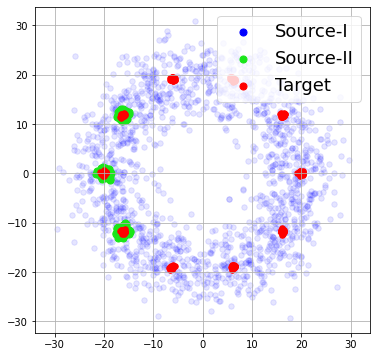

In [2]:
plt.figure(figsize=(6, 6))
scale = 20
target_color = 'red'
source_1_color = 'blue'
source_2_color = (0.1, 0.9, 0.1)


distr_source_1 = FatCircle(r=scale, sigma=4)
distr_source_2 = GaussianMix(centers='circle', sigma=0.5, size=scale)
distr_source_2.centers = distr_source_2.centers[:3]
distr_target = GaussianMix(centers='circle', sigma=0.25, size=scale)

plot_distribution(distr_source_1, count=1500, color=source_1_color, s=30, alpha=0.1)
plot_distribution(distr_source_2, count=500, color=source_2_color, s=50, alpha=1)
plot_distribution(distr_target, count=300, color=target_color, s=30, alpha=1)


# dummy way to show legend with solid dots
plt.scatter([0,], [0,], color=source_1_color, label='Source-I', s=50)
plt.scatter([0,], [0,], color=source_2_color, label='Source-II', s=50)
plt.scatter([0,], [0,], color=target_color, label='Target', s=50)
plt.scatter([0,], [0,], color='white', s=150)

plt.legend(fontsize=18, loc='upper right', framealpha=0.8)
plt.xlim([-30, 30])
plt.grid()

# Training

In [3]:
params = TrainParams(loss='vanila', steps=5_001,  d_steps=4, steps_per_test=250, steps_per_save=50)
out_dir = 'playground_runs'
os.makedirs(out_dir, exist_ok=True)

gen, dis = make_models()
train(gen, dis, distr_source_1, f'{out_dir}/source-1', params=params)

0% | Step 0 :D loss: 1.381 | G loss: 0.675
step 0 | W1_g W1-loss: 20.033
step 0 | W1_g_ema W1-loss: 19.922
4% | Step 250 :D loss: 0.225 | G loss: 5.819
step 250 | W1_g W1-loss: 17.674
step 250 | W1_g_ema W1-loss: 19.568
9% | Step 500 :D loss: 0.229 | G loss: 5.686
step 500 | W1_g W1-loss: 14.761
step 500 | W1_g_ema W1-loss: 15.869
14% | Step 750 :D loss: 0.513 | G loss: 3.703
step 750 | W1_g W1-loss: 12.373
step 750 | W1_g_ema W1-loss: 13.265
19% | Step 1000 :D loss: 0.629 | G loss: 2.291
step 1000 | W1_g W1-loss: 11.998
step 1000 | W1_g_ema W1-loss: 11.600
24% | Step 1250 :D loss: 0.887 | G loss: 1.371
step 1250 | W1_g W1-loss: 12.103
step 1250 | W1_g_ema W1-loss: 12.919
29% | Step 1500 :D loss: 1.062 | G loss: 1.143
step 1500 | W1_g W1-loss: 12.277
step 1500 | W1_g_ema W1-loss: 12.485
34% | Step 1750 :D loss: 0.952 | G loss: 1.093
step 1750 | W1_g W1-loss: 11.759
step 1750 | W1_g_ema W1-loss: 12.524
39% | Step 2000 :D loss: 1.020 | G loss: 1.071
step 2000 | W1_g W1-loss: 12.883
step 

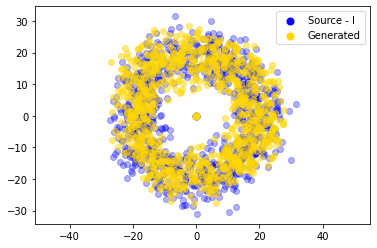

In [6]:
with torch.no_grad():
    xy = gen(torch.randn([1000, gen.dim_z], device='cuda')).cpu()


gen_color = 'gold'
plt.axis('equal')
plot_distribution(distr_source_1, color=source_1_color, alpha=0.3)
plt.scatter(xy[:, 0], xy[:, 1], alpha=0.5, color=gen_color)

plt.scatter([0,], [0,], color=source_1_color, label='Source - I', s=50)
plt.scatter([0,], [0,], color=gen_color, label='Generated', s=50)

plt.legend(loc='upper right')

# Inspect Init Checkpoints

In [20]:
from playground.train import generator_loss, LossType
from playground.precision_recall import recall_metric


dist = distr_target
clusters = dist.centers
n_clusters = len(clusters)


def plot_clusters(axs=None):
    if axs is None:
        axs = plt.gca()
    for i in range(n_clusters):
        color = plt.cm.jet(i / n_clusters)
        axs.scatter(clusters[i, 0], clusters[i, 1], color='red', s=250,
                    linewidths=1, edgecolors='black')


def checkpoint_start_metrics(chkpt):
    G, D = make_models(chkpt)

    with torch.no_grad():
        z = torch.randn([1000, G.dim_z], device='cuda')
        samples = G(z).cpu()
        closest = (samples[None].repeat(n_clusters, 1, 1) - clusters.view(-1, 1, 2))\
            .norm(dim=-1)\
            .min(dim=0).indices

    # compute D-grad
    samples_shifts = nn.Parameter(torch.zeros_like(samples))
    g_loss = generator_loss(D, (samples + samples_shifts).cuda(), LossType.vanila)
    g_loss.backward()
    grad = samples_shifts.grad / samples_shifts.grad.norm(dim=1)[:, None]

    # grad-field quality measure
    direction_to_cluster = torch.stack([clusters[c] for c in closest]) - samples
    sim = torch.cosine_similarity(direction_to_cluster, grad)

    # recall
    recall = recall_metric(dist(1000), samples)

    return sim[sim == sim].mean().item(), recall

### fine-tune to target distribution

In [ ]:
import re


steps = []
cross_entropies = []
sims = []
recalls = []


checkpoints_root = f'{out_dir}/source-1/checkpoints'
checkpoints = [
    f'{checkpoints_root}/{chkpt}' for chkpt in os.listdir(checkpoints_root) if \
    'models' in chkpt
]

for chkpt in tqdm(checkpoints):
    s, r = checkpoint_start_metrics(chkpt)

    try:
        step = int(re.findall('[0-9]+', os.path.basename(chkpt))[0])
    except Exception:
        print(f'unindexed checkpoint {chkpt}, skip it')
        continue

    steps.append(step)
    sims.append(s)
    recalls.append(r)

    # train from the current starting checkpoint
    gen, dis = make_models(chkpt)
    params = TrainParams(loss='vanila', steps=1_001,  d_steps=4, steps_per_test=250, steps_per_save=50)
    train(gen, dis, distr_target, f'{out_dir}/transfers/{step}', params=params)


sims = np.array(sims)
recalls = np.array(recalls)

In [38]:
# load fine-tuned metrics
import json


w1_losses = []

for step in steps:
    metrics_path = f'{out_dir}/transfers/{step}/metrics.json'

    if os.path.isfile(metrics_path):
        with open(metrics_path) as f:
            losses = {int(k): v for k, v in json.load(f).items()}
            w1_losses.append(np.min([l['W1_g'] for l in losses.values()]))

w1_losses = np.array(w1_losses)

### Plot 

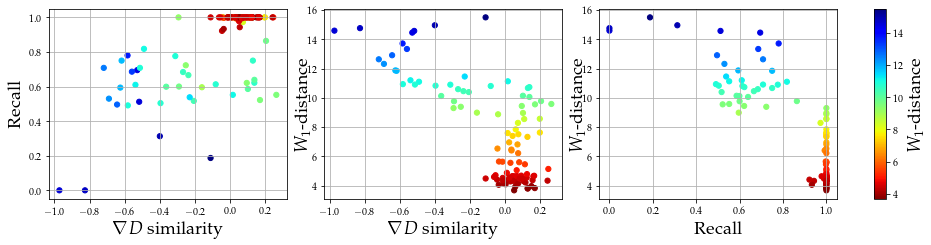

In [231]:
import matplotlib as mpl


colors = plt.cm.jet_r((w1_losses -  w1_losses.min()) / (w1_losses.max() -  w1_losses.min()))

fig, axs = plt.subplots(1, 4, figsize=(15, 3.5), gridspec_kw={'width_ratios': [20, 20, 20, 1]})
for ax in axs[:3]:
    ax.grid()

axs[0].scatter(sims, recalls, c=colors, s=27)
axs[0].set_xlabel(r'$\nabla D$ similarity')
axs[0].set_ylabel('Recall')

axs[1].scatter(sims, w1_losses, c=colors, s=27)
axs[1].set_xlabel(r'$\nabla D$ similarity')
axs[1].set_ylabel('$W_1$-distance', labelpad=-5)

axs[2].scatter(recalls, w1_losses, c=colors, s=27)
axs[2].set_xlabel('Recall')
axs[2].set_ylabel('$W_1$-distance', labelpad=-5)


cmap = mpl.cm.jet_r
norm = mpl.colors.Normalize(vmin=w1_losses.min(), vmax=w1_losses.max())

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=axs[3], orientation='vertical', label='$W_1$-distance')

In [226]:
from scipy import stats


grad_sim_pearson = stats.pearsonr(sims, w1_losses)
w1_init_pearson = stats.pearsonr(recalls, w1_losses)

print(f'Grad-sim corr: {grad_sim_pearson}\nW1-init corr: {w1_init_pearson}')

Grad-sim corr: (-0.7277637020379226, 6.6465932435458355e-18)
W1-init corr: (-0.8430397471830448, 2.0464529671639664e-28)
